#### Saliency map 

In [2]:
import os
import torch 
import matplotlib.pyplot as plt 
from Mobnet import MobNet
from syn_hnet import HNet 
import pandas as pd 
import numpy as np 

%load_ext tensorboard

C:\Users\jaabi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
mroot = 'models'
models = [i for i in os.listdir(mroot) if i.endswith('.pt')]
for model in models:
    print(model)

mnet_sd2.pt
mnet_tr.pt
syn_hnet.pt


In [3]:
from hutils import get_joints, convert_3d_to_2d as cvt3t2, get_crop_uv, crop_and_resize

def get_random_image(tdf = 'synthetic_hand_test.csv'):
    df = pd.read_csv(tdf)
    image_path, _, abs_path, _ = df.sample(1).values[0]
    image_id = os.path.basename(image_path).split('_')[0]
    jpath = os.path.join(abs_path, f'{image_id}_joint_pos.txt')
    image = plt.imread(image_path)
    kpts = cvt3t2(get_joints(jpath)).astype(int)
    h,w,_ = image.shape
    bbox = get_crop_uv(kpts, (h,w), thresh = 30)
    return  image, kpts, bbox

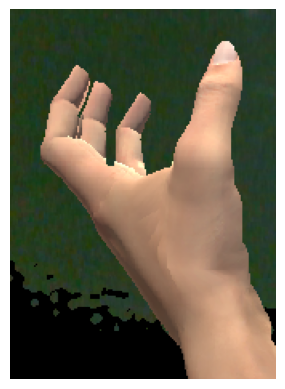

In [4]:
image, kpts, bbox = get_random_image()
x1,y1,x2,y2 = bbox
plt.imshow(image[y1:y2, x1:x2])
plt.axis(False);

In [10]:
def init_models(models = ['mnet_tr.pt','syn_hnet.pt']):
    models = [os.path.join('models', i) for i in models]
    kpts = 42
    verbose = False
    img_size = 299
    hnet = HNet(None, k = kpts, verbose = verbose, img_size = (img_size, img_size))
    hnet.load_state_dict(torch.load(models[1]))
    img_size = 224
    ckpt = os.path.join('models', 'syn_hnet.pt-epoch=02-val_loss=0.0334.ckpt')
    mnet = MobNet.load_from_checkpoint(ckpt)
#     mnet.load_state_dict(torch.load('syn_hnet.pt-epoch=02-val_loss=0.0334.ckpt'))
#     mnet = torch.load(models[0])
    
    return mnet, hnet

In [15]:
def compute_saliency_map(model, inputs, image_shape):
    model.eval()
    image, kpts, bbox = inputs
    image, kpts = crop_and_resize(image, kpts, bbox, image_shape) 
    image = torch.from_numpy(image).to(torch.float32)
    target= torch.tensor(kpts).view(-1, 2).to(torch.float32)
    image = torch.unsqueeze(image.permute(-1, 0, 1), dim = 0)
    image.requires_grad = True

    criterion = torch.nn.SmoothL1Loss()
    
    try:
        output = model(image).view(-1, 2)
    except RuntimeError:
        output = model(image.to('cuda')).view(-1, 2).cpu()
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    
    saliency_map = image.grad.abs().max(1)[0]
    return saliency_map.permute(1, -1, 0).detach().numpy()

def sub_plot(idx, image, title):
    plt.subplot(2,3,idx)
    plt.axis(False)
    plt.title(title)
    plt.imshow(image)

def plot_sm():
    image, kpts, bbox = get_random_image()
    mishape, hishape = (224,224), (299, 299)
    vmimage, _ = crop_and_resize(image.copy(), kpts, bbox, mishape)
    vhimage, _ = crop_and_resize(image.copy(), kpts, bbox, hishape)
    
    mnet, hnet = init_models()
    mnet_sm = compute_saliency_map(mnet, (image.copy(), kpts, bbox), mishape)
    hnet_sm = compute_saliency_map(hnet, (image.copy(), kpts, bbox), hishape)
    
    plt.figure(figsize = (15, 8))
    plt.style.use('dark_background')
    
    sub_plot(1, vmimage, 'OG')
    sub_plot(2, mnet_sm, 'Mnet Saliency Map')
    sub_plot(3, mnet_sm, 'Mnet Saliency Map over OG')
    plt.imshow(vmimage, alpha = .5)
    
    sub_plot(4, vhimage, 'OG')
    sub_plot(5, hnet_sm, 'Hnet Saliency Map')
    sub_plot(6, hnet_sm, 'Hnet Saliency Map over OG')
    plt.imshow(vhimage, alpha = .5)

#### mnet before training 

Loaded the previous state dict onto the current model ...


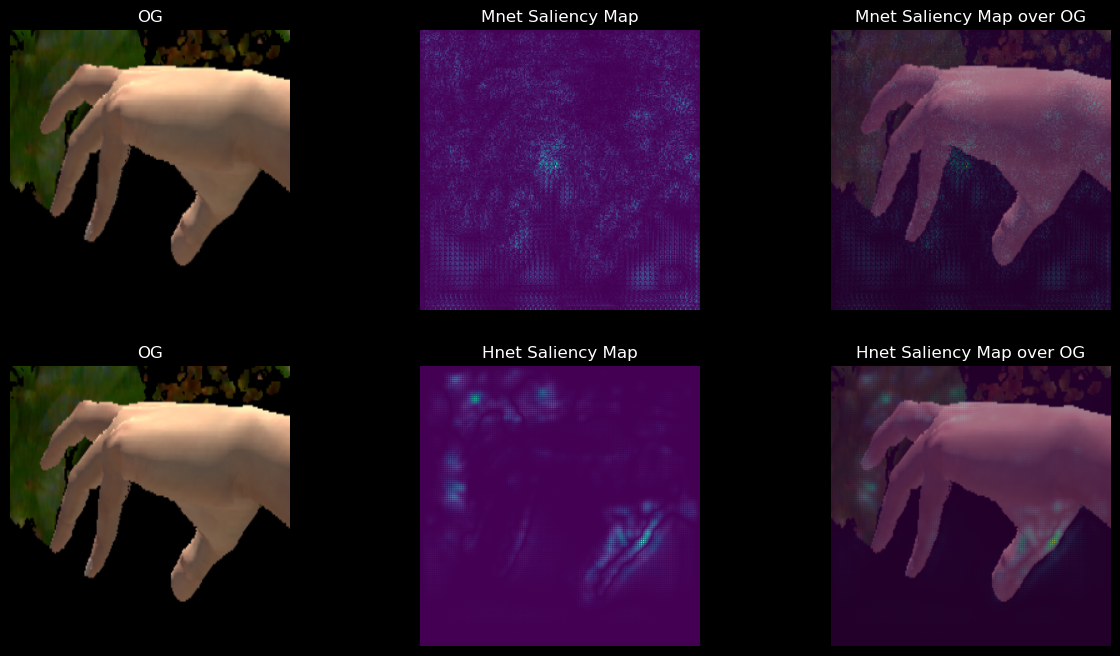

In [39]:
plot_sm()

#### mnet training for 10 epochs 

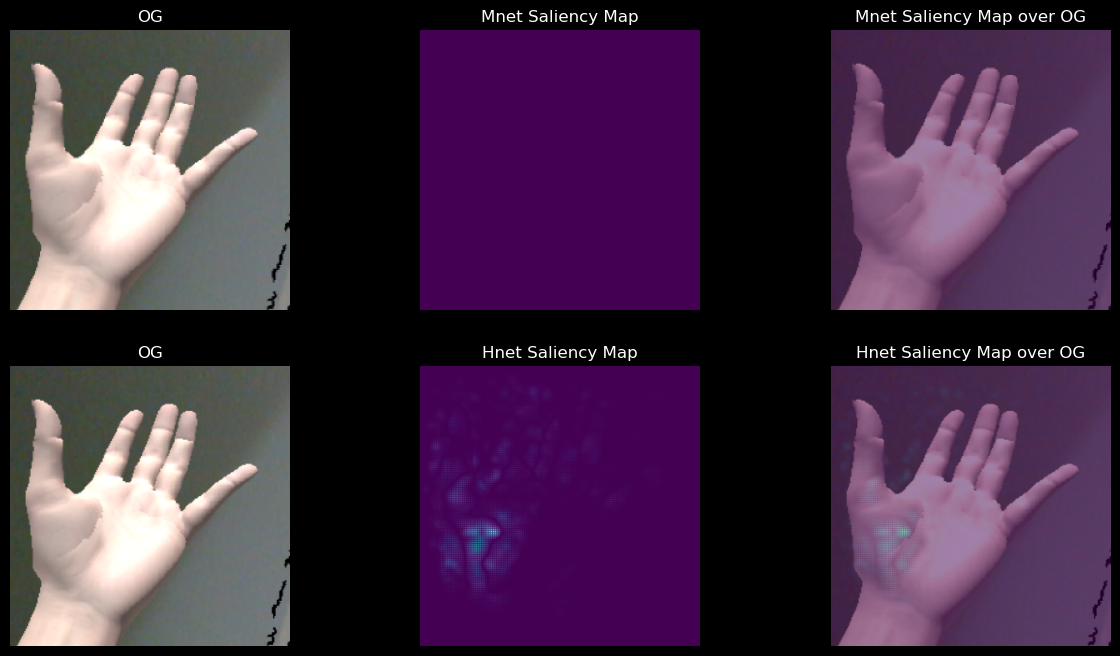

In [10]:
plot_sm()

#### mnet trainied for 20 epochs

C:\Users\jaabi\anaconda3\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(


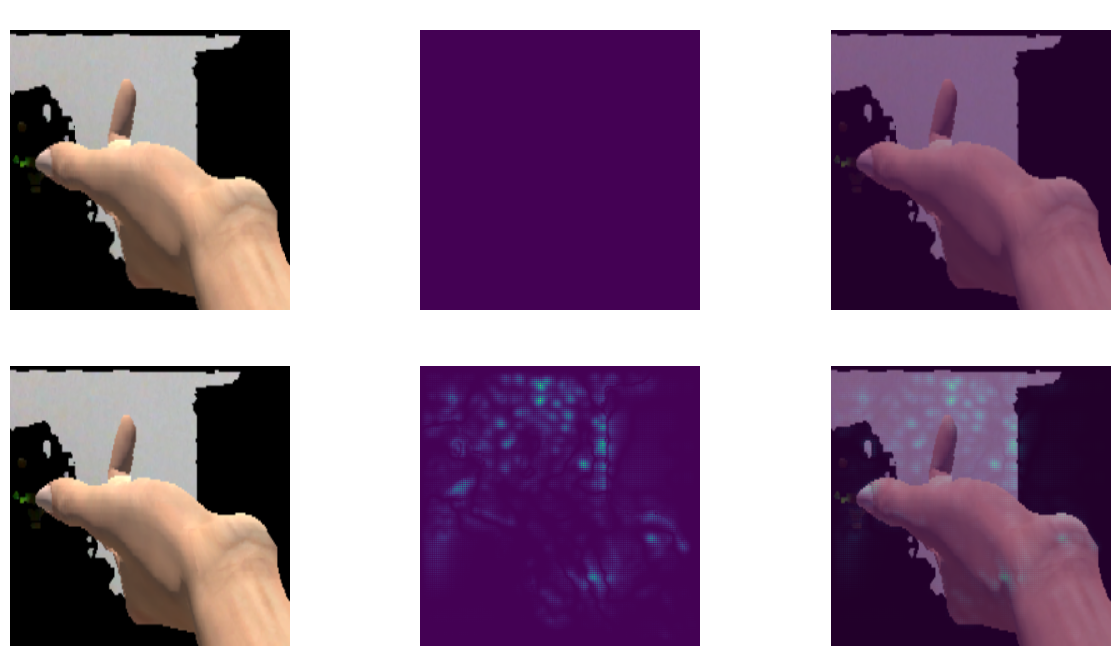

In [16]:
plot_sm()

#### Results 

In [3]:
from glob import glob

dirs = glob(os.path.join('lightning_logs', '*'))
for vis in dirs:
    print(vis)

lightning_logs\resnet_results


In [4]:
%tensorboard --logdir=lightning_logs